# IMPORT REQUIRED LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import pyeeg as pe

!pip install mne
import mne

import os
import time
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

import scipy.signal

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-ciw69auc
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-ciw69auc
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=f011ad70108ab56e6d089d8038308e65fa04fa1d5bfc7679c66126ea4ab0ce68
  Stored in directory: /tmp/pip-ephem-wheel-cache-kr6df76m/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 43.2 MB/s eta 0:00:00


In [ ]:
import torch
# Check CUDA
CUDA = torch.cuda.is_available()
print("CUDA Availability: ", CUDA)
if CUDA:
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda:0')
    !nvidia-smi
else:
    device = torch.device('cpu')

CUDA Availability:  True
Mon Dec 25 08:46:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+

# DATA PREPROCESS

In [ ]:
deapdataset = '/content/drive/MyDrive/EEGDATA/deap_data'
seeddataset = '/content/drive/MyDrive/EEGDATA/seed_data'

channel_14 = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] # 14 Channels chosen to fit Emotiv Epoch+ (AF3、F3、F7、FC5、T7、P7、O1、AF4、F4、F8、FC6、T8、P8、O2)
eeg_channel_14 = ["AF3", "F3", "F7", "FC5", "T7", "P7", "O1", "AF4", "F4", "F8", "FC6", "T8", "P8", "O2"]

channel_32 = [i for i in range(32)]# All Channels
eeg_channel_32 = ["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz",
                  "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"]

# Create a standard montage for the Biosemi 32 channel layout
full_montage = mne.channels.make_standard_montage('biosemi32')
# Extract the positions of your 14 channels from the full montage
selected_ch_14 = {ch: full_montage.get_positions()['ch_pos'][ch] for ch in eeg_channel_14}
selected_ch_32 = {ch: full_montage.get_positions()['ch_pos'][ch] for ch in eeg_channel_32}
# Create a custom montage using the selected channel positions
custom_montage_14 = mne.channels.make_dig_montage(ch_pos=selected_ch_14)
custom_montage_32 = mne.channels.make_dig_montage(ch_pos=selected_ch_32)

band = [4,8,12,16,25,45] # 5 bands
window_size = 256 # Averaging band power of 2 sec
step_size = 16 # Each 0.125 sec update once
sample_rate = 128 # Sampling rate of 128 Hz

In [ ]:
def RAW_Processing(sub, channel, band, window_size, step_size, sample_rate):

    meta = []
    with open(deapdataset + "/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i] #EEG SIGNAL
            #print(data)
            labels = subject["labels"][i] #EMOTION LABEL
            #print(labels)
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = []

                meta_data = [data[j][start : start + window_size] for j in channel]
                # print(np.array(meta_data))

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array, dtype=object))
                start = start + step_size

        meta = np.array(meta)
        print(meta.shape)
        np.save('/content/temp/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
def FFT_Processing(sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(deapdataset + "/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i] #EEG SIGNAL
            #print(data)
            labels = subject["labels"][i] #EMOTION LABEL
            #print(labels)
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = []

                for j in channel:
                    X = data[j][start : start + window_size]
                    Y = pe.bin_power(X, band, sample_rate)
                    meta_data = meta_data + list(Y[0])


                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array, dtype=object))
                start = start + step_size

        meta = np.array(meta)
        print(meta.shape)
        np.save('/content/temp/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
!rm -r /content/temp
!mkdir /content/temp

data_type = 'RAW'
subjectNum = 10
files = []
for n in range(1, subjectNum+1):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

subjectList = files
print("Datatype: " + data_type)
print(subjectList)

rm: cannot remove '/content/temp': No such file or directory
Datatype: RAW
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']


In [ ]:
if data_type == 'RAW':
  for subjects in subjectList:
      RAW_Processing(subjects, channel_14, band, window_size, step_size, sample_rate)
elif data_type == 'FFT':
  for subjects in subjectList:
      FFT_Processing(subjects, channel_32, band, window_size, step_size, sample_rate)

(19520, 2)
(19520, 2)
(19520, 2)
(19520, 2)
(19520, 2)
(19520, 2)
(19520, 2)
(19520, 2)
(19520, 2)
(19520, 2)


# DATASET CREATE & SAVE


In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []
data_info = '_10_32' #num_subject + num_channel


for subjects in subjectList:
    with open('/content/temp/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)

      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

data_training  = np.array(data_training)
label_training = np.array(label_training)
data_testing   = np.array(data_testing)
label_testing  = np.array(label_testing)

!mkdir /content/drive/MyDrive/EEGDATA/temp/

if data_type == 'FFT':
  np.save('/content/drive/MyDrive/EEGDATA/temp/fft_data_training' + data_info, data_training, allow_pickle=True, fix_imports=True)
  np.save('/content/drive/MyDrive/EEGDATA/temp/fft_label_training' + data_info, label_training, allow_pickle=True, fix_imports=True)
  print("FFT training dataset:", data_training.shape, label_training.shape)

  np.save('/content/drive/MyDrive/EEGDATA/temp/fft_data_testing' + data_info, data_testing, allow_pickle=True, fix_imports=True)
  np.save('/content/drive/MyDrive/EEGDATA/temp/fft_label_testing' + data_info, label_testing, allow_pickle=True, fix_imports=True)
  print("FFT testing dataset:", data_testing.shape, label_testing.shape)

else:
  np.save('/content/drive/MyDrive/EEGDATA/temp/data_training' + data_info, data_training, allow_pickle=True, fix_imports=True)
  np.save('/content/drive/MyDrive/EEGDATA/temp/label_training' + data_info, label_training, allow_pickle=True, fix_imports=True)
  print("training dataset:", data_training.shape, label_training.shape)

  np.save('/content/drive/MyDrive/EEGDATA/temp/data_testing' + data_info, data_testing, allow_pickle=True, fix_imports=True)
  np.save('/content/drive/MyDrive/EEGDATA/temp/label_testing' + data_info, label_testing, allow_pickle=True, fix_imports=True)
  print("testing dataset:", data_testing.shape, label_testing.shape)

# DATASET LOAD

In [ ]:
data_type = 'RAW'
data_info = '_10_32' #num_subject + num_channel

In [ ]:
if data_type == 'FFT':
  # Loading training data
  data_training = np.load('/content/drive/MyDrive/EEGDATA/temp/fft_data_training' + data_info + '.npy', allow_pickle=True)
  label_training = np.load('/content/drive/MyDrive/EEGDATA/temp/fft_label_training' + data_info + '.npy', allow_pickle=True)

  # Loading testing data
  data_testing = np.load('/content/drive/MyDrive/EEGDATA/temp/fft_data_testing' + data_info + '.npy', allow_pickle=True)
  label_testing = np.load('/content/drive/MyDrive/EEGDATA/temp/fft_label_testing' + data_info + '.npy', allow_pickle=True)

  data_training = data_training.reshape(data_training.shape[0],1,data_training.shape[1])
  data_testing = data_testing.reshape(data_testing.shape[0],1,data_testing.shape[1])

  print("Loaded FFT training dataset:", data_training.shape, label_training.shape)
  print("Loaded FFT testing dataset:", data_testing.shape, label_testing.shape)

else:
  # Loading training data
  data_training = np.load('/content/drive/MyDrive/EEGDATA/temp/data_training' + data_info + '.npy', allow_pickle=True)
  label_training = np.load('/content/drive/MyDrive/EEGDATA/temp/label_training' + data_info + '.npy', allow_pickle=True)

  # Loading testing data
  data_testing = np.load('/content/drive/MyDrive/EEGDATA/temp/data_testing' + data_info + '.npy', allow_pickle=True)
  label_testing = np.load('/content/drive/MyDrive/EEGDATA/temp/label_testing' + data_info + '.npy', allow_pickle=True)

  print("Loaded RAW training dataset:", data_training.shape, label_training.shape)
  print("Loaded RAW testing dataset:", data_testing.shape, label_testing.shape)

Loaded RAW training dataset: (156160, 32, 256) (156160, 4)
Loaded RAW testing dataset: (39040, 32, 256) (39040, 4)


In [ ]:
print(data_training.shape)
print(label_training.shape)
print(data_testing.shape)
print(label_testing.shape)

(156160, 32, 256)
(156160, 4)
(39040, 32, 256)
(39040, 4)


In [ ]:
label_training

array([[7.71, 7.6 , 6.9 , 7.83],
       [7.71, 7.6 , 6.9 , 7.83],
       [7.71, 7.6 , 6.9 , 7.83],
       ...,
       [5.78, 6.15, 7.04, 6.44],
       [5.78, 6.15, 7.04, 6.44],
       [5.78, 6.15, 7.04, 6.44]])

# DATASET VISUALIZAION

Creating RawArray with float64 data, n_channels=14, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<ipython-input-7-d246b76a61e6>:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_14.set_montage(custom_montage_14)
<ipython-input-7-d246b76a61e6>:9: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  custom_montage_14.plot()


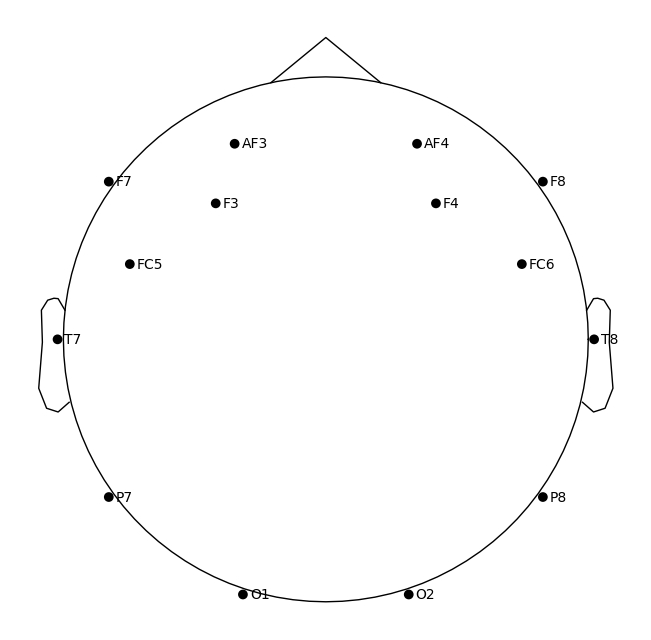

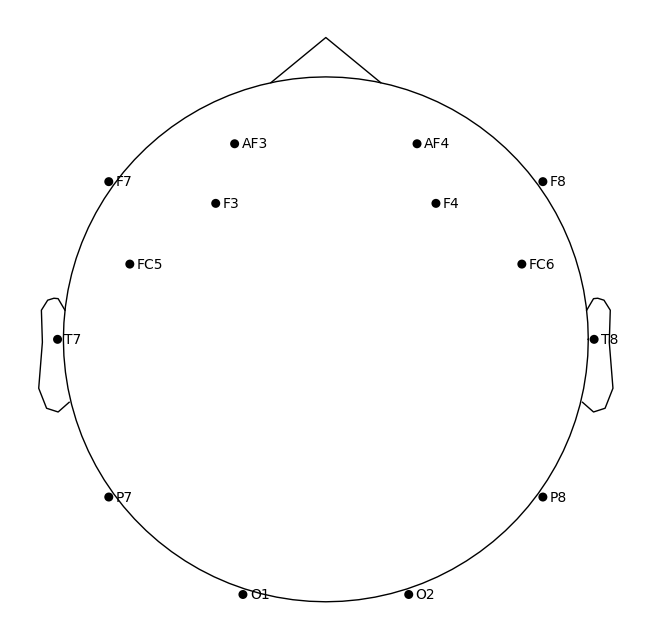

In [ ]:
# Create a sample Raw data object with these channels
info_14 = mne.create_info(ch_names=eeg_channel_14, sfreq=256, ch_types='eeg')
raw_14 = mne.io.RawArray(np.zeros((14, 1)), info_14)

# Apply the custom montage to the Raw object
raw_14.set_montage(custom_montage_14)

# Visualize the electrode layout
custom_montage_14.plot()

Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<ipython-input-8-54d3ddae08ad>:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_32.set_montage(custom_montage_32)
<ipython-input-8-54d3ddae08ad>:9: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  custom_montage_32.plot()


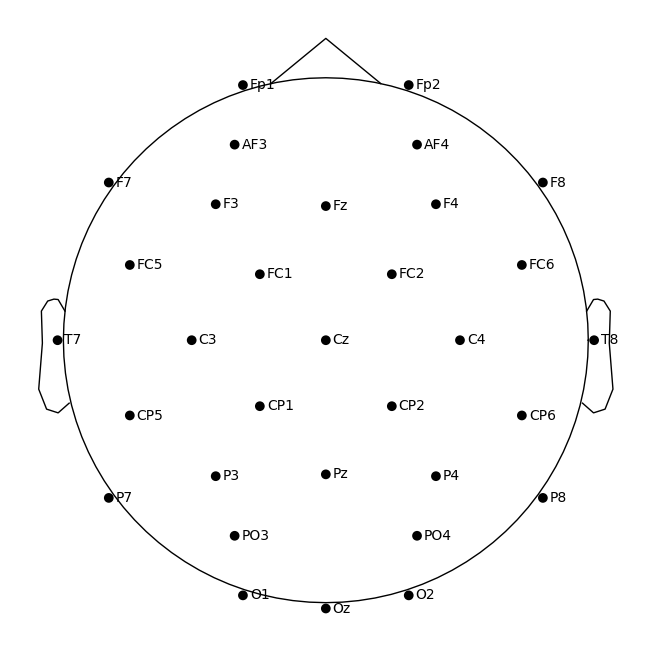

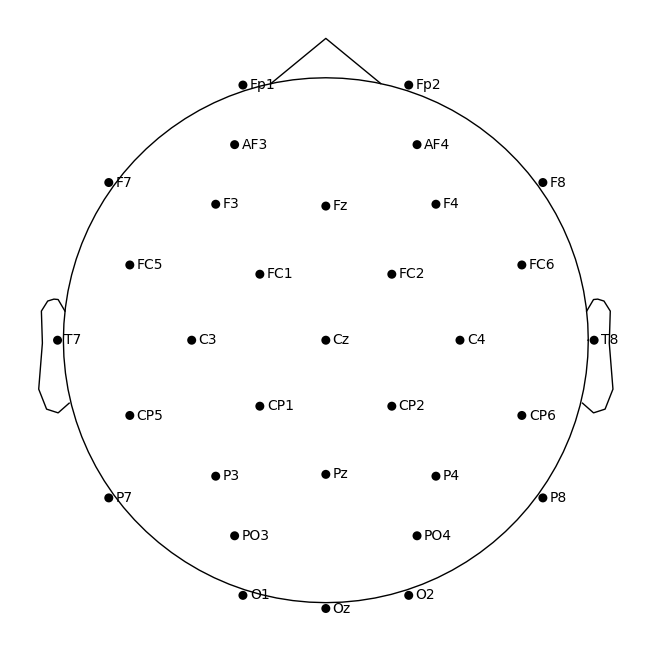

In [ ]:
# Create a sample Raw data object with these channels
info_32 = mne.create_info(ch_names=eeg_channel_32, sfreq=256, ch_types='eeg')
raw_32 = mne.io.RawArray(np.zeros((32, 1)), info_32)

# Apply the custom montage to the Raw object
raw_32.set_montage(custom_montage_32)

# Visualize the electrode layout
custom_montage_32.plot()

In [ ]:
# thresh_valence = np.median(label_training[:,0])
# thresh_arousal = np.median(label_training[:,1])
# print(thresh_valence, thresh_arousal)

thresh_valence = 5.0
thresh_arousal = 5.0

In [ ]:
count = [0,0,0,0]

for row in label_training:

    if row[0] > thresh_valence and row[1] > thresh_arousal:
      count[0] += 1

    elif row[0] < thresh_valence and row[1] > thresh_arousal:
      count[1] += 1

    elif row[0] > thresh_valence and row[1] < thresh_arousal:
      count[2] += 1

    elif row[0] < thresh_valence and row[1] < thresh_arousal:
      count[3] += 1

# Define the English labels for each emotion category
emotion_labels = [

    "HVHA", #High Valance High Arousal
    "LVHA", #Low Valance High Arousal
    "HVLA", #High Valance Low Arousal
    "LVLA" #Low Valance Low Arousal
]

# Print the count for each emotion category
for i, count_value in enumerate(count):
    print(f"Count for {emotion_labels[i]}: {count_value}")

Count for HVHA: 49184
Count for LVHA: 29279
Count for HVLA: 37089
Count for LVLA: 38265


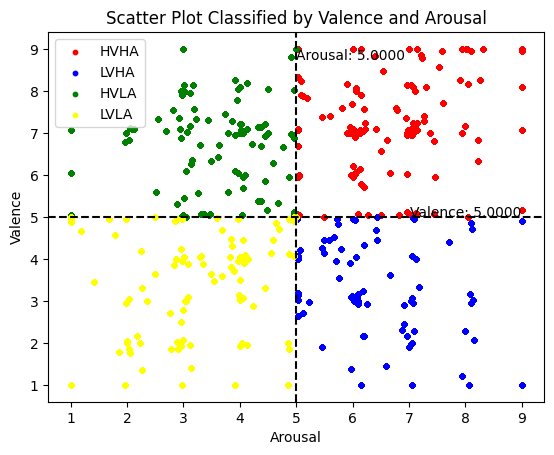

In [ ]:
# Classify points into 4 categories based on the original label_training array
HVHA = label_training[(label_training[:, 0] > thresh_valence) & (label_training[:, 1] > thresh_arousal)]
LVHA = label_training[(label_training[:, 0] < thresh_valence) & (label_training[:, 1] > thresh_arousal)]
HVLA = label_training[(label_training[:, 0] > thresh_valence) & (label_training[:, 1] < thresh_arousal)]
LVLA = label_training[(label_training[:, 0] < thresh_valence) & (label_training[:, 1] < thresh_arousal)]

# Plotting
plt.scatter(HVHA[:, 1], HVHA[:, 0], s=10, color='red', label="HVHA")
plt.scatter(LVHA[:, 1], LVHA[:, 0], s=10, color='blue', label="LVHA")
plt.scatter(HVLA[:, 1], HVLA[:, 0], s=10, color='green', label="HVLA")
plt.scatter(LVLA[:, 1], LVLA[:, 0], s=10, color='yellow', label="LVLA")

# Add a crosshair to divide the quadrants
plt.axhline(thresh_valence, color='black', linestyle='--')
plt.axvline(thresh_arousal, color='black', linestyle='--')

# Display the values of valence and arousal with 4 decimal places
valence_text = f'Valence: {thresh_valence:.4f}'
arousal_text = f'Arousal: {thresh_arousal:.4f}'
plt.text(max(label_training[:, 1]), thresh_valence, valence_text, horizontalalignment='right')
plt.text(thresh_arousal, max(label_training[:, 0]), arousal_text, verticalalignment='top')

# Add labels, title, and legend
plt.xlabel('Arousal')
plt.ylabel('Valence')
plt.title('Scatter Plot Classified by Valence and Arousal')
plt.legend()

# Show plot
plt.show()

# DATASET PREPARATION

In [ ]:
def z_score(data):
  data_mean = np.mean(data, axis=1)
  data_stds = np.std(data, axis=1)
  normalized_data = (data - data_mean[:, np.newaxis]) / data_stds[:, np.newaxis]
  return normalized_data

def min_max_scaling(data):
  data_min = np.min(data, axis=1, keepdims=True)
  data_max = np.max(data, axis=1, keepdims=True)
  normalized_data = (data - data_min) / (data_max - data_min)
  return normalized_data

In [ ]:
from torchvision import transforms

class EEGDataset(Dataset):
  def __init__(self, data, labels, thresh_valence, thresh_arousal):
    self.data           = data
    self.labels         = labels
    self.thresh_valence = thresh_valence
    self.thresh_arousal = thresh_arousal

    self.transform = transforms.Compose([
                                transforms.ToTensor(),
                        ])

  def __getitem__(self, index):
    data = self.data[index]
    # print(data.shape)

    #data = z_score(data)
    #data = min_max_scaling(data)
    data = self.transform(data)

    label = self.labels[index]

    if label[0] > self.thresh_valence and label[1] > self.thresh_arousal:
      return data, torch.tensor([1,0,0,0])

    elif label[0] < self.thresh_valence and label[1] > self.thresh_arousal:
      return data, torch.tensor([0,1,0,0])

    elif label[0] > self.thresh_valence and label[1] < self.thresh_arousal:
      return data, torch.tensor([0,0,1,0])

    elif label[0] < self.thresh_valence and label[1] < self.thresh_arousal:
      return data, torch.tensor([0,0,0,1])
    else:
      return data, torch.tensor([1,0,0,0])

  def __len__(self):
    return len(self.data)

In [ ]:
train_eeg_dataset = EEGDataset(data_training, label_training, thresh_valence, thresh_arousal)
test_eeg_dataset  = EEGDataset(data_testing, label_testing, thresh_valence, thresh_arousal)

print(len(train_eeg_dataset))
d, l = train_eeg_dataset[0]
print(d.shape)
print(l)

156160
torch.Size([1, 32, 256])
tensor([1, 0, 0, 0])


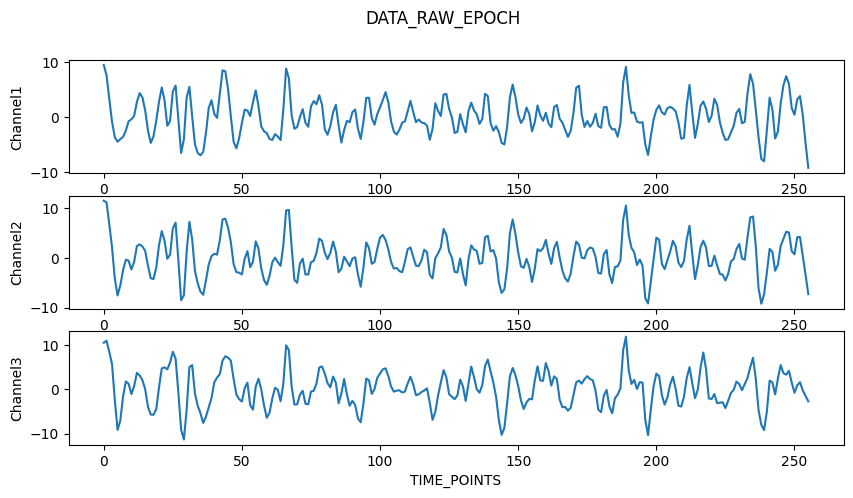

In [ ]:
if data_type == 'RAW':
  num_channels = d.shape[1]  # Total number of channels
  num_channels_visual = 3
  first_channels = range(num_channels_visual)

  # Setting up the plot
  fig, axes = plt.subplots(nrows=num_channels_visual, ncols=1, figsize=(10, 5))
  fig.suptitle('DATA_RAW_EPOCH')

  # Plotting the first three channels
  for i, channel in enumerate(first_channels):
      axes[i].plot(d[0][channel].detach().numpy())
      #axes[i].set_title(f'Channel {channel+1}')
      axes[i].set_xlabel('TIME_POINTS')
      axes[i].set_ylabel(f'Channel{channel+1}')

else:
  plt.figure(figsize=(10, 5))
  plt.plot(d[0][0].detach().numpy())
  plt.title('DATA_FFT_EPOCH')  # Add a title to the plot
  plt.xlabel('TIME_POINTS')  # Optionally, label the x-axis
  plt.ylabel('FEATURE')  # Optionally, label the y-axis
  plt.show()  # Display the plot

In [ ]:
train_eeg_dataloader = DataLoader(train_eeg_dataset,batch_size= 256,shuffle=True, num_workers=2)
test_eeg_dataloader = DataLoader(test_eeg_dataset,batch_size= 256, shuffle=False, num_workers=2)

# Display the shape of data and labels in the training set
train_data_sample, train_label_sample = train_eeg_dataset[0]
print("Training Data Sample Shape:", train_data_sample.shape)
print("Training Label Sample Shape:", train_label_sample.shape)

# Display the shape of data and labels in the testing set
test_data_sample, test_label_sample = test_eeg_dataset[0]
print("Testing Data Sample Shape:", test_data_sample.shape)
print("Testing Label Sample Shape:", test_label_sample.shape)


Training Data Sample Shape: torch.Size([1, 32, 256])
Training Label Sample Shape: torch.Size([4])
Testing Data Sample Shape: torch.Size([1, 32, 256])
Testing Label Sample Shape: torch.Size([4])


# MODEL DEFINITION

In [ ]:
import torch
import torch.nn as nn

class Cnn1dModel(nn.Module):
    def __init__(self, num_classes):
        super(Cnn1dModel, self).__init__()

        # Define the 1D convolutional layers
        self.convs = nn.Sequential(
            nn.Conv1d(32, 1024, kernel_size=75, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

            nn.Conv1d(1024, 512, kernel_size=50, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

            nn.Conv1d(512, 256, kernel_size=25, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
        )

        self.lstm1 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)

        # Fully connected layers
        self.fc_input_size = 32*128  # Hidden_size of LSTM
        self.linears = nn.Sequential(
            nn.Linear(self.fc_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):

        # Convolution layers
        x = self.convs(x)
        #print("After conv layers: ", x.shape)  # Print the shape after convolution layers

        # Reshaping for LSTM layer
        x = x.permute(0, 2, 1)
        #print("Before LSTM layers: ", x.shape)  # Print the shape before LSTM layers

        # LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        #print("After LSTM layer: ", x.shape)  # Print the shape after the second LSTM layer

        # Flatten the output for the linear layers
        x = x.reshape(x.shape[0], -1)  # Flatten
        #print("Before linear layers: ", x.shape)  # Print the shape before linear layers

        x = self.linears(x)

        return x

    def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the model
model = Cnn1dModel(num_classes=4)

# Print the model architecture
print(model)
print(f"Total trainable parameters: {model.count_parameters()}")

Cnn1dModel(
  (convs): Sequential(
    (0): Conv1d(32, 1024, kernel_size=(75,), stride=(1,), padding=same)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(1024, 512, kernel_size=(50,), stride=(1,), padding=same)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(512, 256, kernel_size=(25,), stride=(1,), padding=same)
    (9): ReLU()
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
  )
  (lstm1): LSTM(256, 256, batch_first=True)
  (lstm2): LSTM(256, 128, batch_first=True)
  (linears): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=

In [ ]:
import torch
import torch.nn as nn

class Cnn1dModel_FFT(nn.Module):
    def __init__(self, num_classes):
        super(Cnn1dModel_FFT, self).__init__()

        # Define the 1D convolutional layers
        # First Convolutional block
        self.convs = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=512, kernel_size=50, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

            nn.Conv1d(in_channels=512, out_channels=256, kernel_size=25, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

        )

        self.lstm1 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)

        # Fully connected layers
        self.fc_input_size = 17*128  # Hidden_size of LSTM
        self.linears = nn.Sequential(
            nn.Linear(self.fc_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):

        # Convolution layers
        x = self.convs(x)
        #print("After conv layers: ", x.shape)  # Print the shape after convolution layers

        # Reshaping for LSTM layer
        #x = x.unsqueeze(0)
        x = x.permute(0,2,1)
        #print("Before LSTM layers: ", x.shape)  # Print the shape before LSTM layers

        # LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        #print("After LSTM layer: ", x.shape)  # Print the shape after the second LSTM layer

        # Flatten the output for the linear layers
        x = x.reshape(x.shape[0], -1)  # Flatten
        #print("Before linear layers: ", x.shape)  # Print the shape before linear layers

        x = self.linears(x)

        return x

    def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the model
model = Cnn1dModel_FFT(num_classes=4)

# Print the model architecture
print(model)
print(f"Total trainable parameters: {model.count_parameters()}")

Cnn1dModel_FFT(
  (convs): Sequential(
    (0): Conv1d(1, 512, kernel_size=(50,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(512, 256, kernel_size=(25,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (lstm1): LSTM(256, 256, batch_first=True)
  (lstm2): LSTM(256, 128, batch_first=True)
  (linears): Sequential(
    (0): Linear(in_features=2176, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
    (7): Softmax(dim=1)
  )
)


# MODEL TRAINING

In [ ]:
if data_type =='FFT':
  model = Cnn1dModel_FFT(num_classes=4)
  print("FFT Training")

else:
  model = Cnn1dModel(num_classes=4)
  print("RAW Training")

RAW Training


In [ ]:
# Test sample
model.to(device)
id = 1
data_p, label_p = test_eeg_dataset[id]
data_p = data_p.to(device).float()
label_p = label_p.float().to(device)

# Make predictions
yhat = model.forward(data_p.to(device)).float()

print(label_p)
print(yhat)

tensor([1., 0., 0., 0.], device='cuda:0')
tensor([[0.2430, 0.2772, 0.2293, 0.2505]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
EPOCHS  = 100
results = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}
optim   = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
loss    = nn.CrossEntropyLoss()
# Early Stopping
patience = 10
patience_counter = 0
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

In [ ]:
model.to(device)
total_data = len(train_eeg_dataloader)
for epoch in range(EPOCHS):
    # ------training------
    epoch_losses = []
    epoch_aucs = []
    model.train()
    for idx, (x, y) in enumerate(train_eeg_dataloader):
        x    = x.squeeze(1).to(torch.float)
        yhat = model.forward(x.to(device)).float()    # Find predicted
        y    = y.float().to(device)                   # label to device
        out  = loss(yhat, y)                          # find loss between predicted and label

        # accuracy
        labels  = torch.argmax(y,dim=1)
        pred    = torch.argmax(yhat,dim=1)
        correct = (labels == pred).sum().item()
        epoch_aucs.append(correct)


        # Backpropagation step
        optim.zero_grad()
        out.backward()
        optim.step()

        epoch_losses.append(out.item())

        if (idx+1) % 50 == 0:
          print("Epoch: {}/{}\t batch: {}/{}\tTrain Loss: {:.4f}\t".format(epoch+1, EPOCHS, idx+1, total_data,out.item()) )


    epoch_loss = np.mean(epoch_losses)
    epoch_auc = np.sum(epoch_aucs) / len(train_eeg_dataset)

    # -----validation-----
    model.eval()
    epoch_val_losses = []
    epoch_val_aucs = []
    with torch.no_grad():
        for x, y in test_eeg_dataloader:
            x    = x.squeeze(1)
            x    = x.to(torch.float)
            yhat = model.forward(x.to(device)).float() # Find predicted
            y    = y.float().to(device)                   # label to device
            out  = loss(yhat, y)
            epoch_val_losses.append(out.item())

            # accuracy
            gt      = torch.argmax(y,dim=1)
            pred    = torch.argmax(yhat,dim=1)
            correct = (gt == pred).sum().item()
            epoch_val_aucs.append(correct)


    epoch_val_loss = np.mean(epoch_val_losses)
    epoch_val_auc  = np.sum(epoch_val_aucs) / len(test_eeg_dataset)


    # populate results
    results['loss'].append( epoch_loss )
    results['val_loss'].append( epoch_val_loss )
    results['auc'].append( epoch_auc )
    results['val_auc'].append( epoch_val_auc )

    if best_val_acc < epoch_val_auc:
      best_val_acc = epoch_val_auc
      best_model_state = model.state_dict()

    if epoch_val_loss < best_val_loss:
      best_val_loss = epoch_val_loss
      patience_counter = 0
    else:
      patience_counter += 1

    print("\nEpoch {}/{}\tTrain Loss: {:.4f}\tTest Loss: {:.4f}\tTrain Acc: {:.4f}\tTest Acc: {:.4f}\tBest Acc: {:.4f}\n".format(
          epoch+1, EPOCHS, epoch_loss, epoch_val_loss, epoch_auc, epoch_val_auc,best_val_acc) )

    # Early Stopping
    if patience_counter >= patience:
      print("Early stopping triggered. Training stopped.")
      break

Epoch: 1/100	 batch: 50/610	Train Loss: 1.3852	
Epoch: 1/100	 batch: 100/610	Train Loss: 1.3854	
Epoch: 1/100	 batch: 150/610	Train Loss: 1.3840	
Epoch: 1/100	 batch: 200/610	Train Loss: 1.3672	
Epoch: 1/100	 batch: 250/610	Train Loss: 1.3565	
Epoch: 1/100	 batch: 300/610	Train Loss: 1.3658	
Epoch: 1/100	 batch: 350/610	Train Loss: 1.3628	
Epoch: 1/100	 batch: 400/610	Train Loss: 1.3624	
Epoch: 1/100	 batch: 450/610	Train Loss: 1.3409	
Epoch: 1/100	 batch: 500/610	Train Loss: 1.3192	
Epoch: 1/100	 batch: 550/610	Train Loss: 1.3457	
Epoch: 1/100	 batch: 600/610	Train Loss: 1.3281	

Epoch 1/100	Train Loss: 1.3606	Test Loss: 1.3160	Train Acc: 0.3249	Test Acc: 0.3921

Epoch: 2/100	 batch: 50/610	Train Loss: 1.3121	
Epoch: 2/100	 batch: 100/610	Train Loss: 1.2766	
Epoch: 2/100	 batch: 150/610	Train Loss: 1.3118	
Epoch: 2/100	 batch: 200/610	Train Loss: 1.2987	
Epoch: 2/100	 batch: 250/610	Train Loss: 1.3006	
Epoch: 2/100	 batch: 300/610	Train Loss: 1.2842	
Epoch: 2/100	 batch: 350/610	Train

In [ ]:
f"{results['val_auc'][-1]*100:.2f}"

'96.73'

In [ ]:
if not os.path.exists('/content/drive/MyDrive/EEGMODEL'):
  os.mkdir('/content/drive/MyDrive/EEGMODEL')

# Save only the model's state dictionary

model_name = model_filename = f"{results['val_auc'][-1]*100:.2f}_1dcnn3_lstm2_sub{subjectNum}_e{EPOCHS}"
model_save_path = '/content/drive/MyDrive/EEGMODEL/' + model_name + '/'

if not os.path.exists(model_save_path):
  os.mkdir(model_save_path)

torch.save(model.state_dict(), model_save_path + model_name + '.pth')
#torch.save(best_model_state, model_save_path + 'best_' + model_name + '.pth')

model.load_state_dict(torch.load(model_save_path + model_name + '.pth'))
model.to(device)

# results = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}
result_save_path = model_save_path + model_name + '.pkl'
with open(result_save_path, 'wb') as file:
    pickle.dump(results, file)

# MODEL EVALUATION

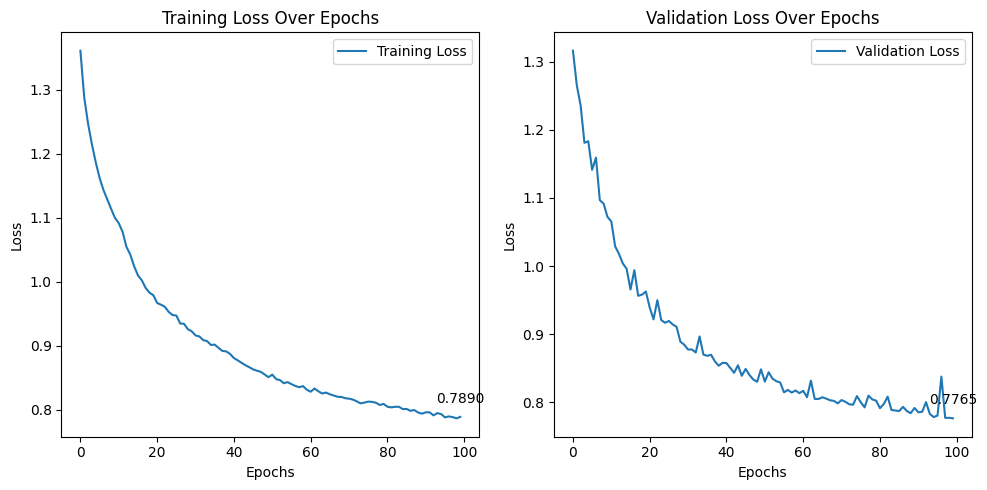

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Set the size for the Loss plot

# Plot Training Loss
plt.subplot(1, 2, 1)  # First position in a 1 row by 2 columns layout
plt.plot(results['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Annotate the last point for Training Loss
plt.annotate(f'{results["loss"][-1]:.4f}',
             (len(results['loss'])-1, results['loss'][-1]),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')

# Plot Validation Loss
plt.subplot(1, 2, 2)  # Second position in a 1 row by 2 columns layout
plt.plot(results['val_loss'], label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Annotate the last point for Validation Loss
plt.annotate(f'{results["val_loss"][-1]:.4f}',
             (len(results['val_loss'])-1, results['val_loss'][-1]),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')

plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure area
plt.savefig(model_save_path + 'LOSS.png', dpi=300)
plt.show()

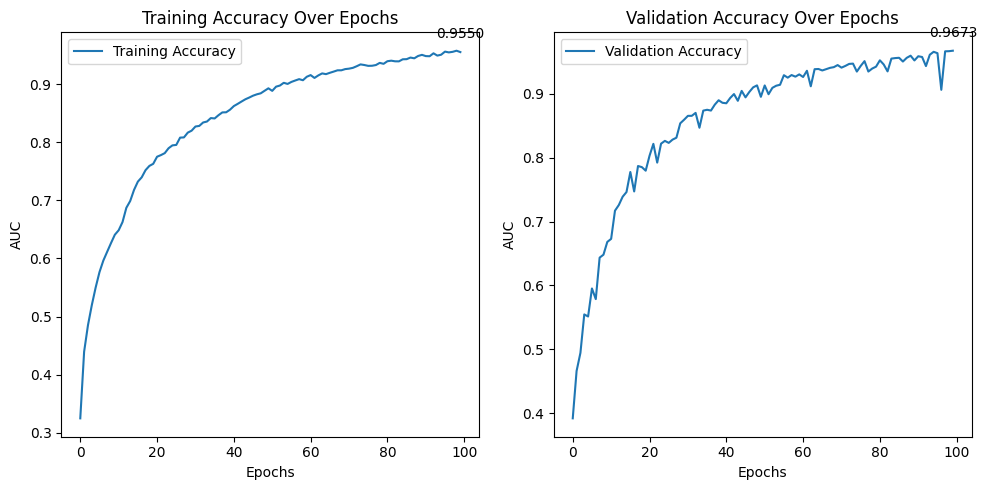

In [ ]:
plt.figure(figsize=(10, 5))  # Set the size for the AUC plot

# Plot Training AUC
plt.subplot(1, 2, 1)  # First position in a 1 row by 2 columns layout
plt.plot(results['auc'], label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
# Annotate the last point for Training AUC
plt.annotate(f'{results["auc"][-1]:.4f}',
             (len(results['auc'])-1, results['auc'][-1]),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')

# Plot Validation AUC
plt.subplot(1, 2, 2)  # Second position in a 1 row by 2 columns layout
plt.plot(results['val_auc'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
# Annotate the last point for Validation AUC
plt.annotate(f'{results["val_auc"][-1]:.4f}',
             (len(results['val_auc'])-1, results['val_auc'][-1]),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')

plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure area
plt.savefig(model_save_path + 'ACC.png', dpi=300)
plt.show()

In [ ]:
# Test sample
id = 10
data_p, label_p = test_eeg_dataset[id]
data_p = data_p.to(device)
data_p = data_p.to(torch.float)

yhat = model.forward(data_p.to(device)).float() # Find predicted
label_p= label_p.float().to(device)                   # label to device

print(label_p)
print(yhat)

tensor([1., 0., 0., 0.], device='cuda:0')
tensor([[9.9987e-01, 1.5615e-05, 7.7506e-05, 3.8185e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
model.eval()
epoch_val_losses = []
epoch_val_aucs = []
with torch.no_grad():
    for x, y in test_eeg_dataloader:
        x    = x.squeeze(1)
        x    = x.to(torch.float)
        yhat = model.forward(x.to(device)).float() # Find predicted
        y    = y.float().to(device)                   # label to device

        # accuracy
        gt      = torch.argmax(y,dim=1)
        pred    = torch.argmax(yhat,dim=1)
        correct = (gt == pred).sum().item()
        epoch_val_aucs.append(correct)


epoch_val_auc  = np.sum(epoch_val_aucs) / len(test_eeg_dataset)
print('Accuracy: ', epoch_val_auc)

Accuracy:  0.9673411885245902
